In [1]:
# Это просто чтобы на проекторе всё было красиво.
# Не обращайте внимания

from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 1.8em;
line-height:1.0em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.4em;
line-height:1.3em;
padding-left:2em;
padding-right:2em;
}
</style>
""")

# Кластеризация

[Кластеризация](https://ru.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7) - это один из видов задач обучения без учителя. Задача заключается в разбиении всех объектов на группы похожих между собой объектов и сильно отличающихся от всех остальных. Так как строгого понятия похожести объектов как такового нет, то алгоритмов кластеризации много, да и каждый алгоритм имеет много вариантов работы.

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png)

## KMeans

Метод k-means - это один из наиболее популярных методов кластеризации. Основная идея метода заключается в том, что на каждой итерации пересчитывается центр масс (центроид) для каждого кластера, полученного на предыдущем шаге, затем объекты снова разбиваются на кластеры согласно тому, какой из новых центроидов находится ближе.
Более формально, алгоритм принимает на вход выборку $X_1, \dots, X_N$ и параметр $k$, указывающий необходимое число кластеров. Выходом алгоритма является набор из $k$ центроидов $\{\mu_1, \dots, \mu_k\}$, с помощью которых кластеризация осуществляется путём отнесения каждого объекту к ближайшему центроиду. Все точки внутри одного кластера ближе к центроиду этого кластера, чем к центроиду любого другого кластера.
Метод может быть сформулирован как задача оптимизации, а именно, минимизации суммарного квадратичного отклонения точек кластеров от центров этих кластеров по центроидам и кластерам: $$\sum_{i=1}^k \sum_{X_n \in C_i} ||X_n - \mu_i||^2 \rightarrow \min, \text{где $C_i$ - это $i$-ый кластер, $\mu_i$ - это центр масс кластера $C_i$.}$$
Решение такой задачи оптимизации является NP-трудной задачей, однако существует простой итеративный алгоритм, позволяющий найти локальный минимум указанного функционала. Алгоритм представляет собой последовательное чередование двух шагов до сходимости.
Предположим, что как-то (например, случайно) выбраны начальные положения центроидов $\mu_1, \dots, \mu_k$.

1. Этап кластеризациu. На данном этапе происходит кластеризация выборки, как было описано выше: каждый объект относится к кластеру ближайшего к нему центроида. Формально, $$C_i = \{X_n : ||X_n - \mu_i|| \leq ||X_n - \mu_j||, \text{ для всех $j \in \{1, \dots, k\}$}\}.$$

2. Этап обновления центроидов. На данном этапе центроиды пересчитываются, как центры масс только что построенных кластеров. Формально, $$\mu_i = \frac{1}{|C_i|}\sum_{X_n \in C_i} X_n.$$

Этот процесс продолжается, пока центроиды и кластеризация продолжают изменяться. Алгоритм гарантированно сходится, однако не гарантируется достижение глобального минимума, а только одного из локальных минимумов. Другим недостатком алгоритма является то, что итоговая кластеризация зависит от выбора исходных центров кластеров. На практике алгоритм запускается несколько раз из различных начальных приближений, а полученные результаты некоторым образом усредняются. Стоит также отметить, что число кластеров необходимо знать заранее. Существуют различные эвристики, позволяющие выбирать в некотором смысле оптимальное число кластеров.

_взято из материалов курса [ODS](https://habrahabr.ru/company/ods/)_

### Литература

- http://scikit-learn.org/stable/modules/clustering.html
- https://habrahabr.ru/company/ods/blog/325654/
- https://ru.wikipedia.org/wiki/Кластерный_анализ

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# Зафиксируем случайность, чтобы каждый раз получалось одно и тоже
np.random.seed(seed=42)

Рассмотрим как работае алгоритм кластеризации KMeans на синтетическом примере.

Бросим на плоскость случайно точки с разными параметрами случайности, чтобы образовались кластеры.

In [3]:
import sklearn
sklearn.__version__

'0.19.1'

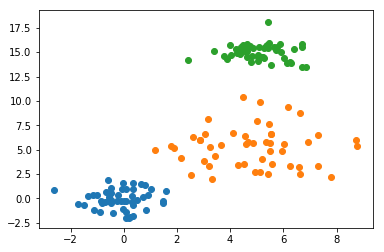

In [3]:
p1 = np.random.normal(loc=0, scale=1, size=(50,2))
p2 = np.random.normal(loc=5, scale=2, size=(50,2))
p3 = np.random.normal(loc=10, scale=0.8, size=(50,2)) - np.array([5, -5])

X = np.concatenate((p1, p2, p3))

plt.scatter(p1[:,0], p1[:, 1])
plt.scatter(p2[:,0], p2[:, 1])
plt.scatter(p3[:,0], p3[:, 1])

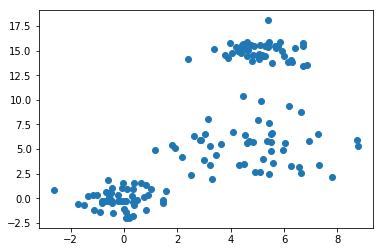

In [4]:
plt.scatter(X[:, 0], X[:, 1])

Рассмотрим пошагово работу алгоритма KMneans на основе обычного евклидова расстояния.

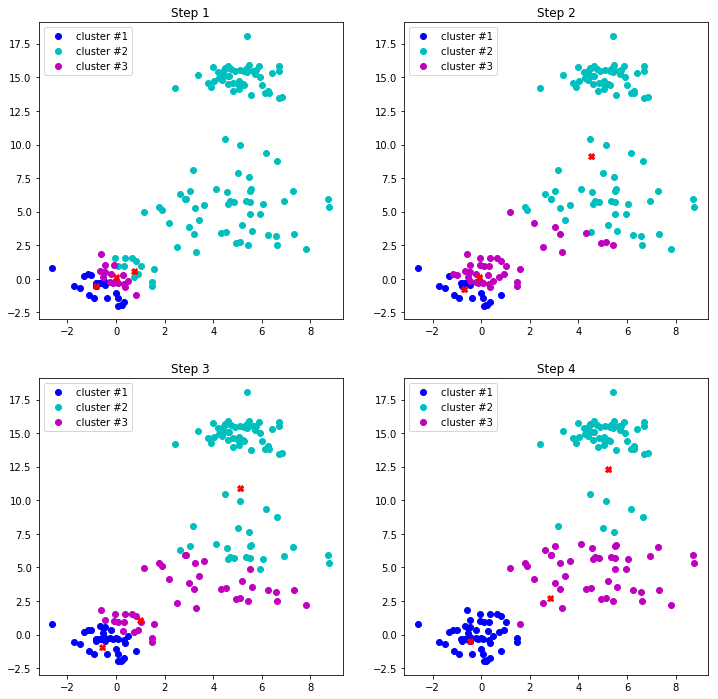

In [5]:
# Пример взят отсюда: https://habrahabr.ru/company/ods/blog/325654/

# В scipy есть замечательная функция, которая считает расстояния
# между парами точек из двух массивов, подающихся ей на вход
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
from scipy.spatial.distance import cdist

centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

STEPS = 3

for i in range(STEPS):
    # Считаем расстояния от наблюдений до центроид
    distances = cdist(X, centroids)
    # Смотрим, до какой центроиде каждой точке ближе всего
    labels = distances.argmin(axis=1)

    # Положим в каждую новую центроиду геометрический центр её точек
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)

    cent_history.append(centroids)
    

# А теперь нарисуем всю эту красоту
plt.figure(figsize=(12, 12))
for i in range(STEPS + 1):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)

    plt.subplot((STEPS + 1) // 2, (STEPS + 1) // 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

# MNIST

Рассморим датасет рукописных цирф MNIST http://yann.lecun.com/exdb/mnist/

In [6]:
from sklearn import datasets

X, y = datasets.load_digits(return_X_y=True)

print("Экземпляров: {}\nРазмер изображения: {}x{}".format(X.shape[0], np.sqrt(X.shape[1]), np.sqrt(X.shape[1])))

Экземпляров: 1797
Размер изображения: 8.0x8.0


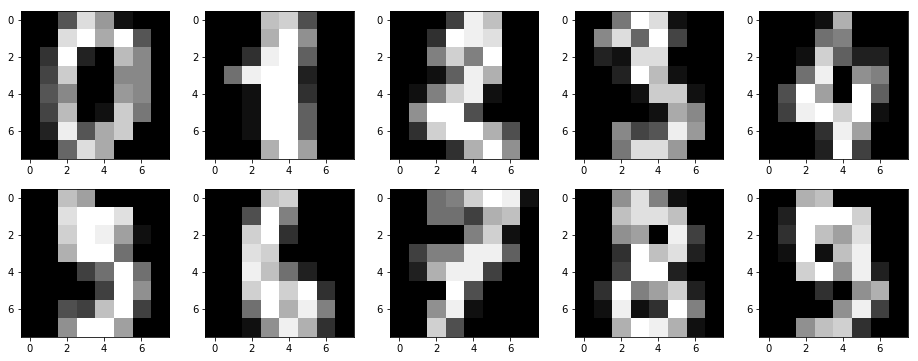

In [7]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray')

In [8]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=10)
clf.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA -  [Метод главных компонент](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82).

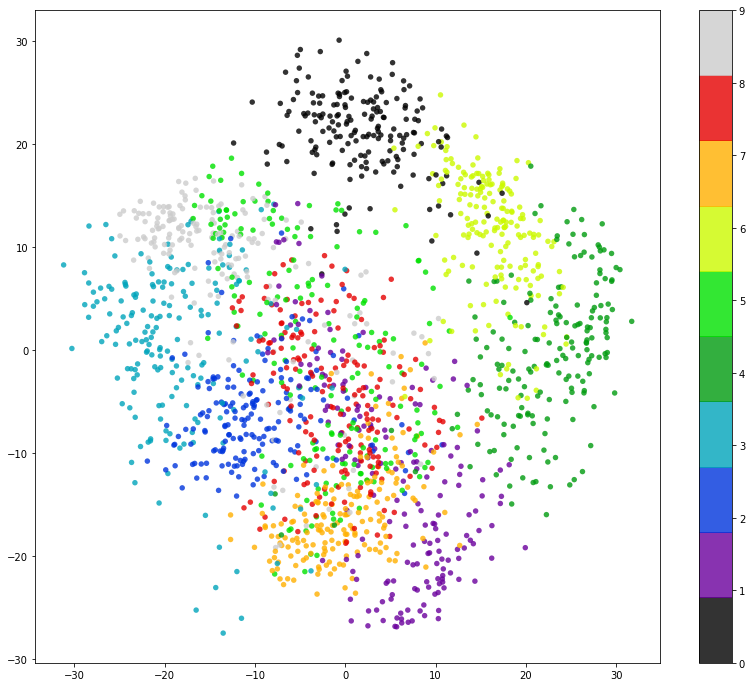

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)

X_reduced = pca.fit_transform(X)
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

А теперь посмотрим как расставил границы наш алгоритм KMeans. Как видим - хоть цвета и перепутаны, но сами кластеры угадываются.

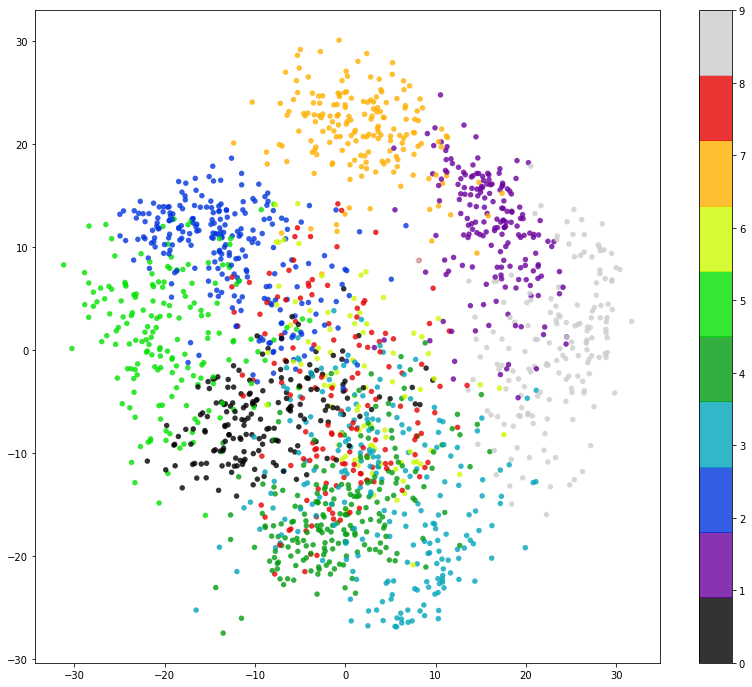

In [10]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=clf.labels_, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

Визуализируем центры кластеров как изображения. Как видим они даже похожи на настоящие цифры.

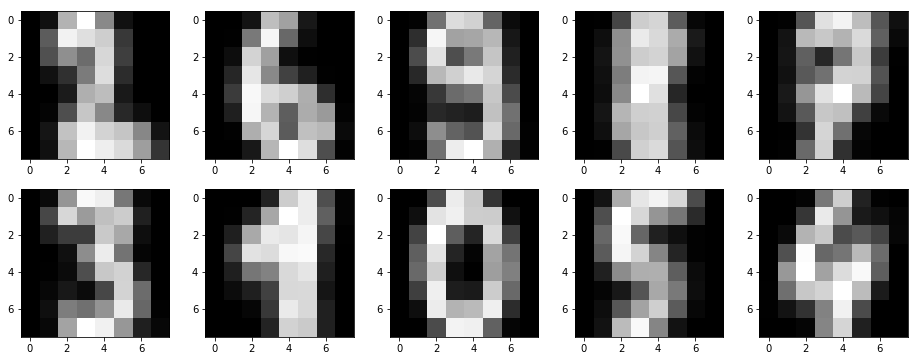

In [11]:
plt.figure(figsize=(16, 6))

for i, center in enumerate(clf.cluster_centers_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(center[:].reshape([8,8]), cmap='gray')

Существуют и другие методы понижения размерности, например t-SNE, но он намного медленнее чем PCA.

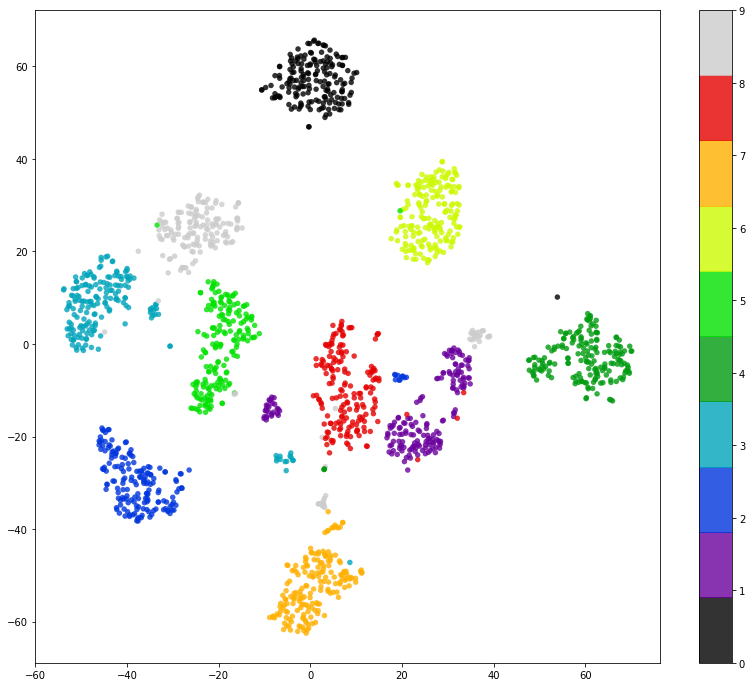

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=42)
X_reduced_t = tsne.fit_transform(X)

plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

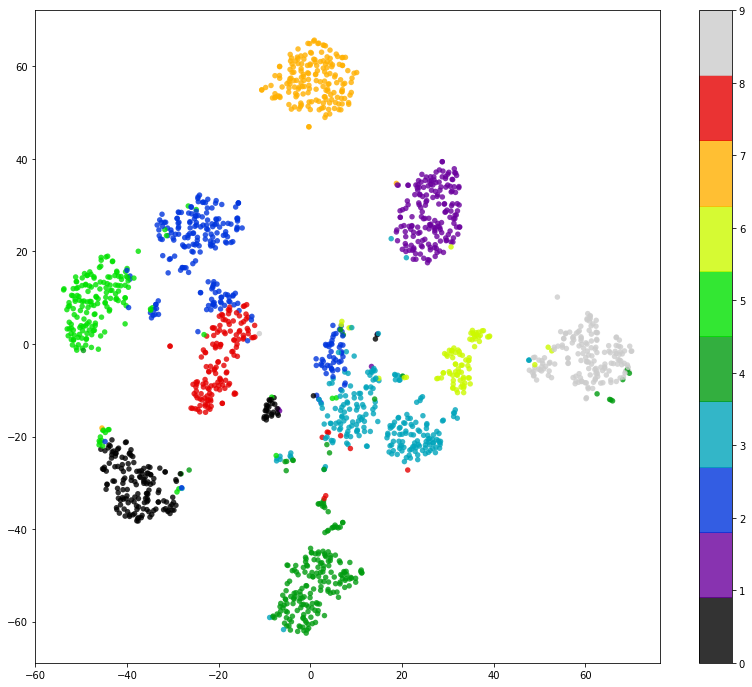

In [13]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=clf.labels_, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

## Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше дург от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого фнукционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

Рассмотрим это на примере KMeans.

In [14]:
data = datasets.load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['species'] = data.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Это всем известный датасет с ирисами Фишера. Всего там 3 класса.

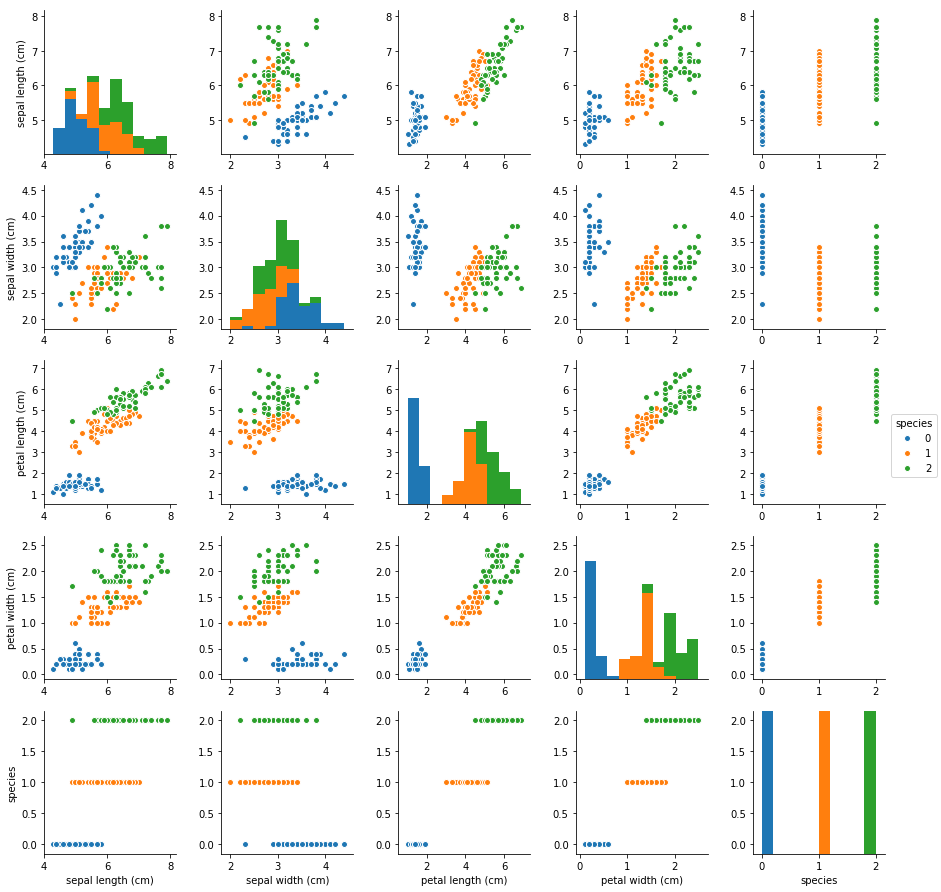

In [15]:
sns.pairplot(df, hue='species')

In [16]:
inertia = []
N = 40
for k in range(1, N):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df.drop(['species'], axis=1))
    inertia.append(np.sqrt(kmeans.inertia_))


На графике видно, что инертность падает не так быстро в районе 3-6 кластеров. Так и есть, на самом деле их 3.

Text(0,0.5,'$J(C_k)$')

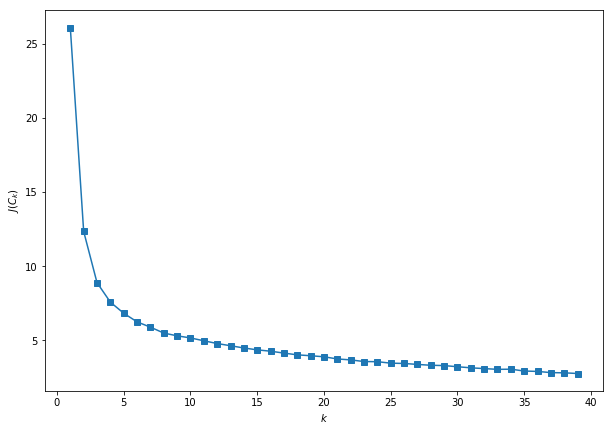

In [17]:
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

Силуэт
Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. 

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

In [18]:
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib.pyplot import cm

def draw_sil(X, y, range_n_clusters = [2, 3, 4, 5, 6]):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()
        
def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

For n_clusters = 2 The average silhouette_score is : 0.382405


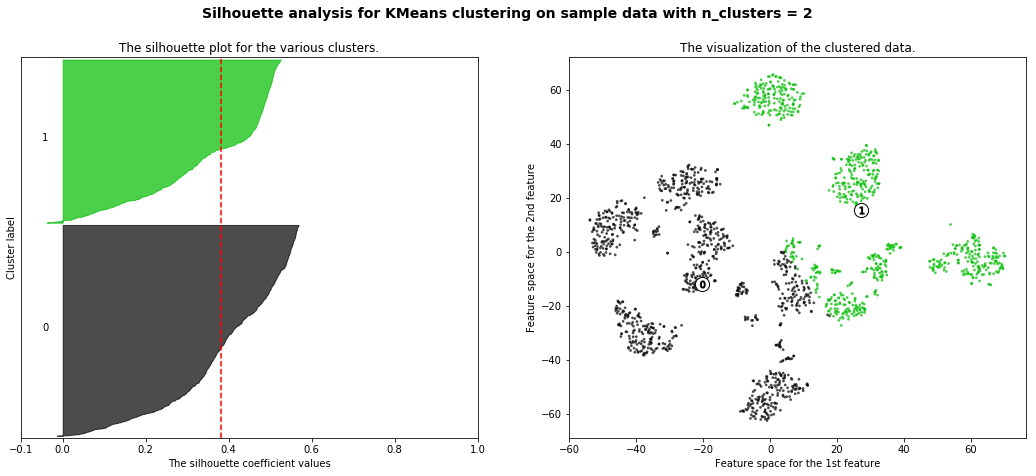

For n_clusters = 3 The average silhouette_score is : 0.443266


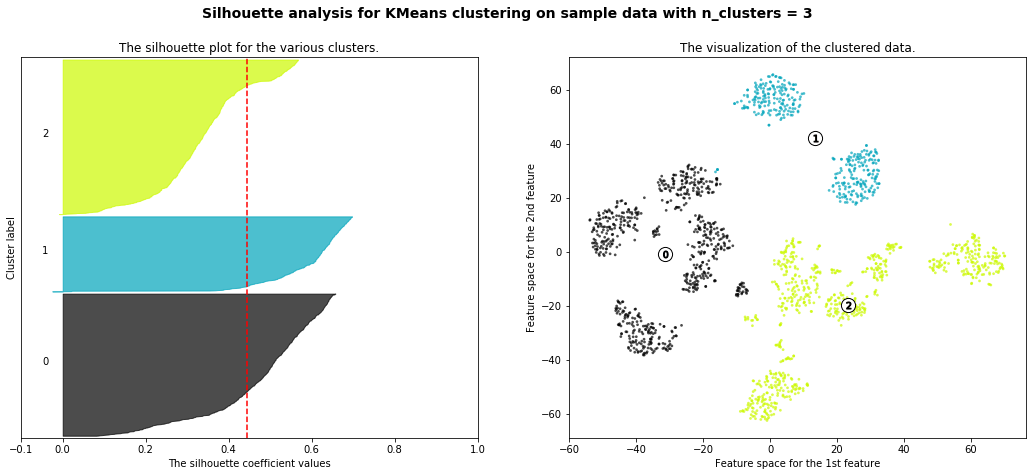

For n_clusters = 4 The average silhouette_score is : 0.472885


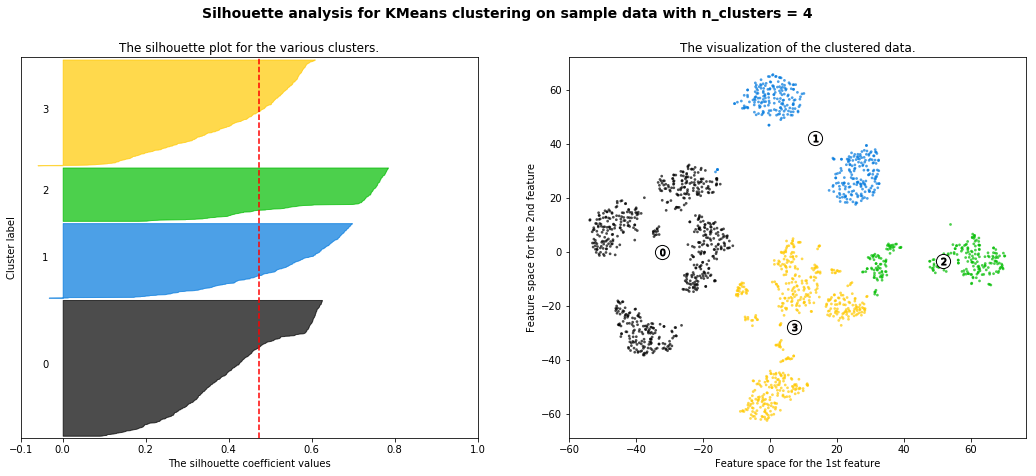

For n_clusters = 5 The average silhouette_score is : 0.493731


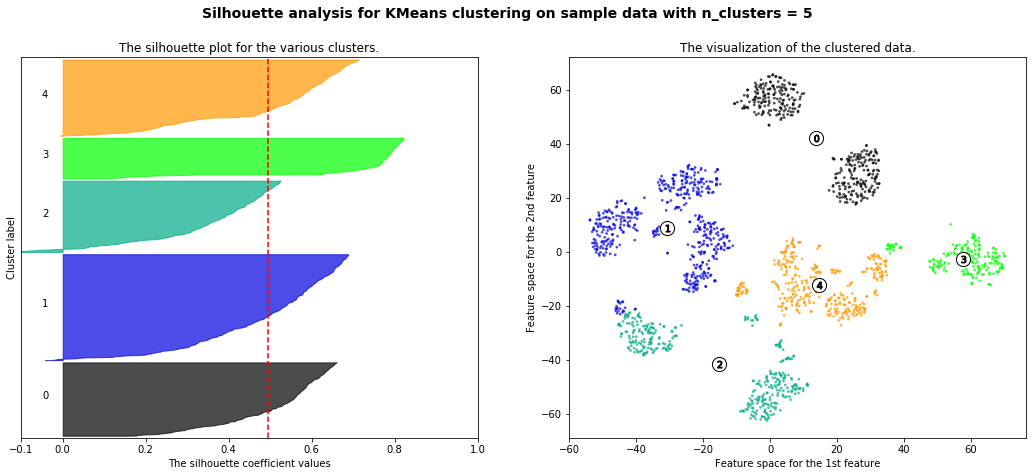

For n_clusters = 6 The average silhouette_score is : 0.537953


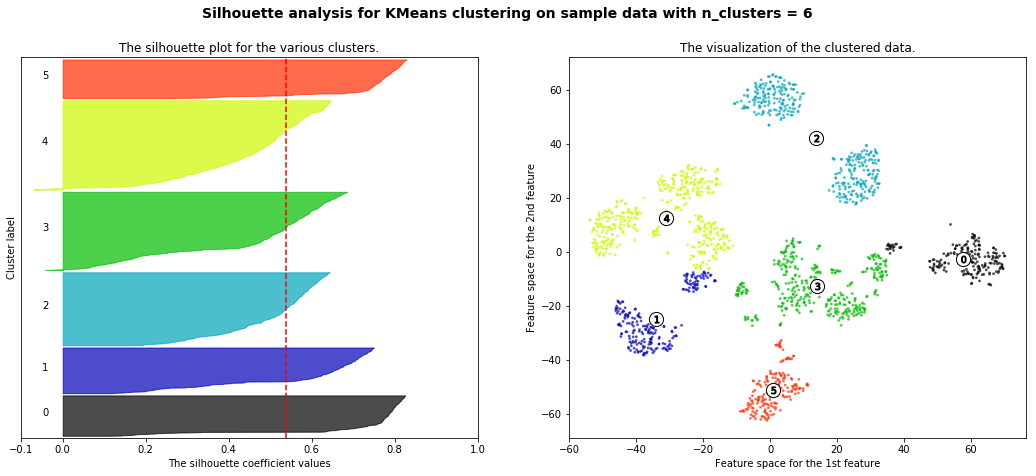

For n_clusters = 10 The average silhouette_score is : 0.628194


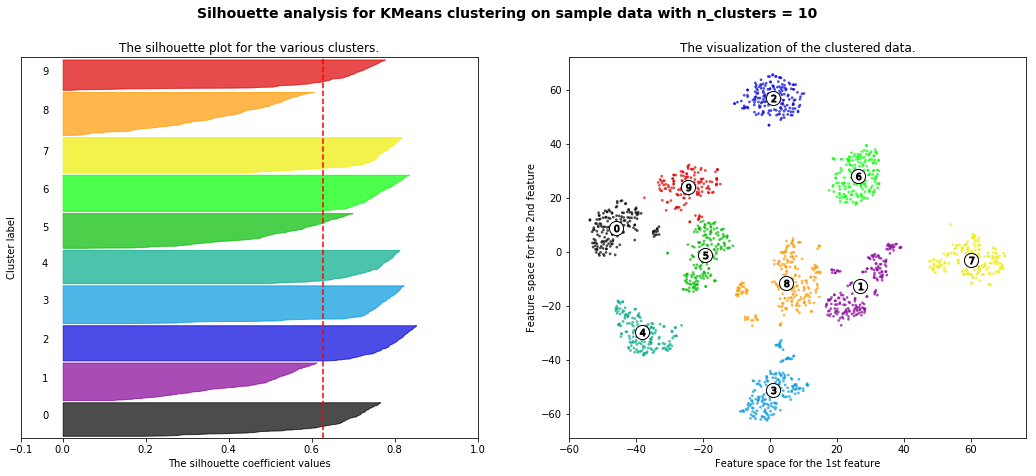

For n_clusters = 12 The average silhouette_score is : 0.623562


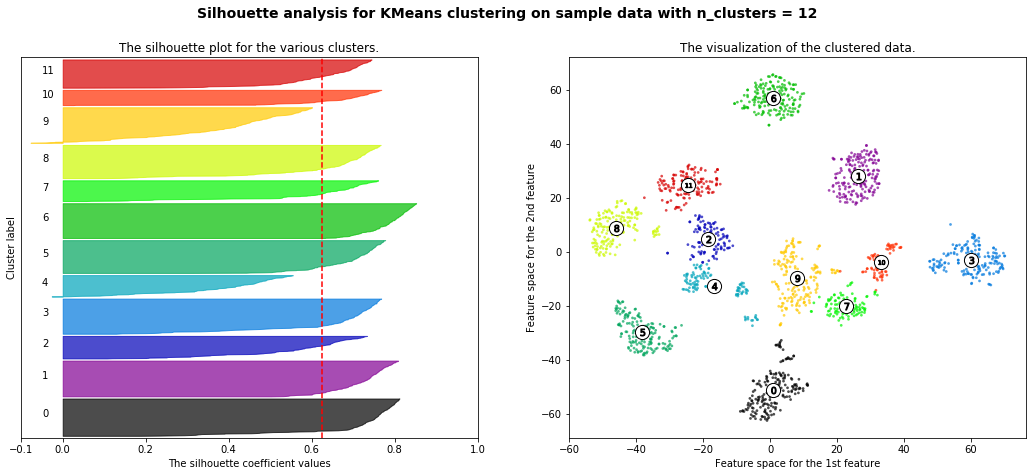

For n_clusters = 13 The average silhouette_score is : 0.622495


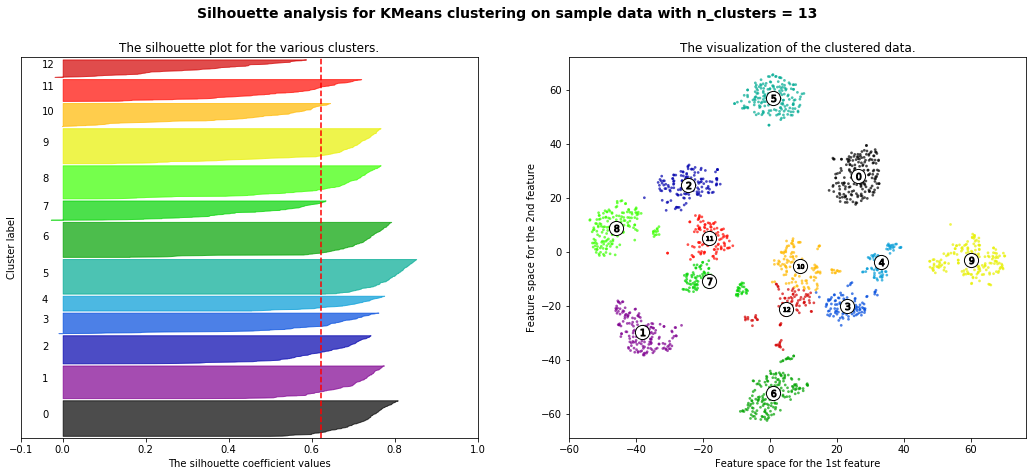

For n_clusters = 20 The average silhouette_score is : 0.52126


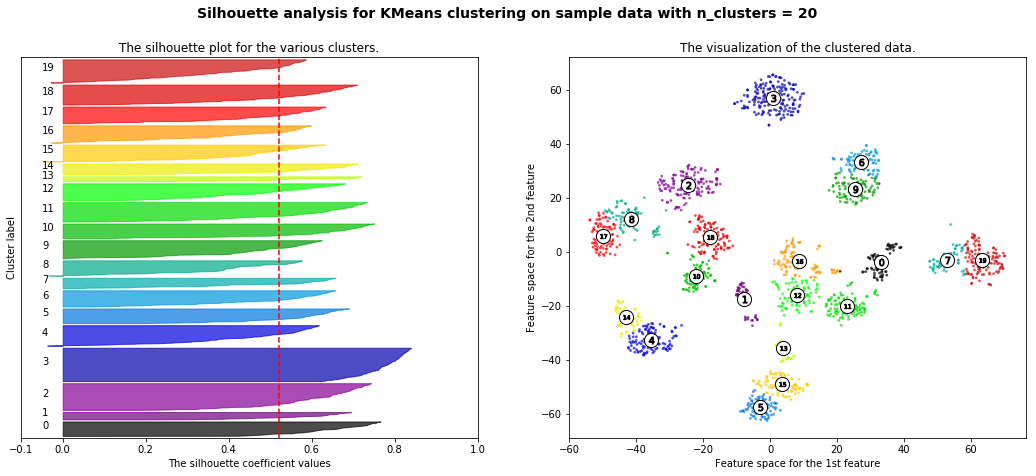

In [19]:
draw_sil(X_reduced_t, y, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20])

Посмотрим на изменения значения коэффициента силуэта. Ожидается, что оптимальное количество кластеров там, где коэффициент наибольший.

В нашем случае это 10 - действительно так!

10

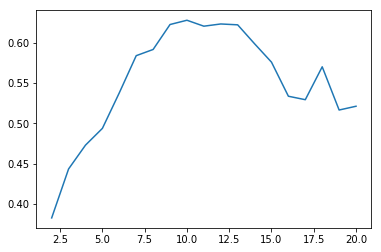

In [20]:
draw_sil_score(X_reduced_t, range_n_clusters=range(2,21))

## Кластеризация рекомендаций фильмов

In [21]:
movies = pd.read_csv('../../data/imdb_movies.csv.gz', index_col='movieId')
ratings = pd.read_csv('../../data/imdb_ratings.csv.gz')

print(movies.shape)
print(ratings.shape)

(9125, 2)
(100004, 4)


In [22]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [23]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [24]:
# ratings.pivot_table(index='movieId', values='rating', columns='userId',dropna=True)

In [25]:
from itertools import chain
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

In [26]:
genres = set(flatmap(
    lambda x: x.split("|"), 
    movies['genres'].unique()))

genres.remove('(no genres listed)')
genres.remove('IMAX')
genres = list(genres)
print(genres)

['Children', 'Romance', 'Horror', 'Adventure', 'Film-Noir', 'Comedy', 'Thriller', 'War', 'Animation', 'Action', 'Mystery', 'Documentary', 'Crime', 'Sci-Fi', 'Fantasy', 'Musical', 'Western', 'Drama']


In [27]:
movies_genres = pd.DataFrame(index=movies.index)
for g in genres:
    movies_genres[g] = movies['genres'].str.contains(g).astype(int)
print(movies_genres.shape)
movies_genres.head()

(9125, 18)


,Children,Romance,Horror,Adventure,Film-Noir,Comedy,Thriller,War,Animation,Action,Mystery,Documentary,Crime,Sci-Fi,Fantasy,Musical,Western,Drama
movieId,,,,,,,,,,,,,,,,,,
1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
df_m = ratings.join(movies_genres, on='movieId').drop(['timestamp', 'movieId'], axis=1)
df_m[genres] = df_m[genres].multiply(df_m['rating'], axis='index')
df_m = df_m.drop(['rating'], axis=1).replace(0, np.NaN) # чтобы посчитать mean без учета непросмотренных фильмов
df_m.head()

,userId,Children,Romance,Horror,Adventure,Film-Noir,Comedy,Thriller,War,Animation,Action,Mystery,Documentary,Crime,Sci-Fi,Fantasy,Musical,Western,Drama
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5
1,1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0
2,1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [29]:
df = df_m.groupby('userId').mean()
df.fillna(-1, inplace=True)
print(df.shape)
df.head()

(671, 18)


,Children,Romance,Horror,Adventure,Film-Noir,Comedy,Thriller,War,Animation,Action,Mystery,Documentary,Crime,Sci-Fi,Fantasy,Musical,Western,Drama
userId,,,,,,,,,,,,,,,,,,
1,2.500000,3.500000,3.000000,2.166667,-1.0,2.000000,2.833333,2.000000,2.000000,2.800000,-1.000000,-1.000000,2.500000,2.400000,2.125000,3.000000,3.0,2.571429
2,3.500000,3.590909,3.500000,3.750000,-1.0,3.093750,3.333333,3.800000,3.666667,3.315789,4.000000,-1.000000,3.666667,3.800000,3.400000,3.750000,5.0,3.615385
3,2.700000,3.650000,3.375000,3.300000,-1.0,3.611111,3.545455,4.166667,2.875000,3.468750,3.750000,3.666667,3.700000,3.142857,3.000000,2.500000,4.0,3.920000
4,4.634146,4.500000,3.944444,4.338710,5.0,4.329545,4.022727,4.750000,4.708333,4.274194,4.090909,4.000000,4.157895,4.255814,4.567568,4.833333,3.0,4.464286
5,3.892857,4.081081,3.875000,3.825000,-1.0,3.981818,3.625000,4.000000,3.900000,4.000000,3.333333,3.666667,3.450000,4.000000,3.750000,4.250000,-1.0,3.807692


In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

clf = KMeans(n_clusters=5)
clf.fit(scaler.fit_transform(df))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Index(['Children', 'Romance', 'Horror', 'Adventure', 'Film-Noir', 'Comedy',
       'Thriller', 'War', 'Animation', 'Action', 'Mystery', 'Documentary',
       'Crime', 'Sci-Fi', 'Fantasy', 'Musical', 'Western', 'Drama'],
      dtype='object')


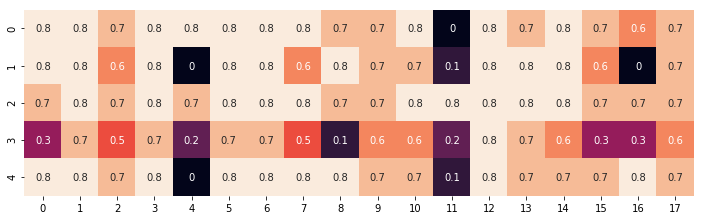

In [31]:
plt.figure(figsize=(12,14))
print(df.columns)
sns.heatmap(np.round(clf.cluster_centers_, 1), annot=True, square=True, cbar=False)

In [32]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
pca = TSNE(n_components=2, random_state=42, init='pca')

scaler = MinMaxScaler(feature_range=(0,1))
d = pca.fit_transform(scaler.fit_transform(df))

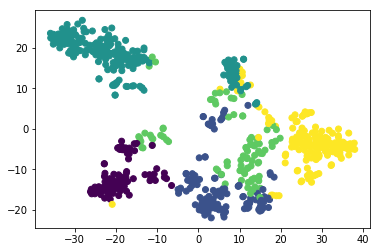

In [33]:
plt.scatter(d[:,0], d[:,1], c=clf.labels_)

## Кластеризация признаков

В предыдущем примере мы нашли кластеры похожих в предпочтениях людей. Теперь попробуем найти похожие жанры, основываясь на рейтингах людей, если это, конечно, возможно.

In [34]:
df = df_m.groupby('userId').mean()
df.fillna(0, inplace=True)
print(df.shape)
df.head()

(671, 18)


,Children,Romance,Horror,Adventure,Film-Noir,Comedy,Thriller,War,Animation,Action,Mystery,Documentary,Crime,Sci-Fi,Fantasy,Musical,Western,Drama
userId,,,,,,,,,,,,,,,,,,
1,2.500000,3.500000,3.000000,2.166667,0.0,2.000000,2.833333,2.000000,2.000000,2.800000,0.000000,0.000000,2.500000,2.400000,2.125000,3.000000,3.0,2.571429
2,3.500000,3.590909,3.500000,3.750000,0.0,3.093750,3.333333,3.800000,3.666667,3.315789,4.000000,0.000000,3.666667,3.800000,3.400000,3.750000,5.0,3.615385
3,2.700000,3.650000,3.375000,3.300000,0.0,3.611111,3.545455,4.166667,2.875000,3.468750,3.750000,3.666667,3.700000,3.142857,3.000000,2.500000,4.0,3.920000
4,4.634146,4.500000,3.944444,4.338710,5.0,4.329545,4.022727,4.750000,4.708333,4.274194,4.090909,4.000000,4.157895,4.255814,4.567568,4.833333,3.0,4.464286
5,3.892857,4.081081,3.875000,3.825000,0.0,3.981818,3.625000,4.000000,3.900000,4.000000,3.333333,3.666667,3.450000,4.000000,3.750000,4.250000,0.0,3.807692


In [35]:
df.T

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
Children,2.500000,3.500000,2.700000,4.634146,3.892857,3.200000,3.785714,3.500000,3.000000,0.000000,...,4.000000,4.250000,3.633333,3.537500,2.666667,4.000000,3.000000,0.000000,4.000000,4.333333
Romance,3.500000,3.590909,3.650000,4.500000,4.081081,2.900000,2.933333,3.717391,3.875000,3.857143,...,3.437500,3.500000,3.696078,3.282443,2.400000,3.260870,5.000000,3.250000,3.714286,3.869565
Horror,3.000000,3.500000,3.375000,3.944444,3.875000,3.333333,2.500000,3.857143,4.000000,3.428571,...,0.000000,4.000000,3.645161,2.772727,3.000000,0.000000,5.000000,2.571429,5.000000,4.000000
Adventure,2.166667,3.750000,3.300000,4.338710,3.825000,3.733333,3.656250,3.863636,3.166667,3.923077,...,3.200000,3.875000,3.796154,3.445783,3.100000,3.571429,3.000000,3.800000,3.400000,4.086207
Film-Noir,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,3.500000,0.000000,0.000000,...,0.000000,0.000000,3.833333,0.000000,0.000000,0.000000,0.000000,5.000000,1.500000,0.000000
Comedy,2.000000,3.093750,3.611111,4.329545,3.981818,2.906250,3.540541,3.796875,3.714286,3.583333,...,3.347826,3.785714,3.709677,3.198068,2.705882,3.875000,3.444444,3.400000,3.857143,3.810000
Thriller,2.833333,3.333333,3.545455,4.022727,3.625000,2.722222,3.000000,4.075758,3.600000,3.500000,...,3.052632,3.687500,3.811203,3.175676,3.071429,3.500000,4.500000,3.076923,3.900000,4.052632
War,2.000000,3.800000,4.166667,4.750000,4.000000,4.166667,3.600000,4.083333,3.666667,4.000000,...,4.666667,4.000000,3.661290,3.615385,3.333333,3.833333,4.500000,0.000000,4.333333,3.857143
Animation,2.000000,3.666667,2.875000,4.708333,3.900000,3.500000,4.083333,3.500000,3.333333,0.000000,...,3.666667,4.333333,3.775000,3.717391,2.500000,4.000000,3.000000,0.000000,4.000000,4.250000
Action,2.800000,3.315789,3.468750,4.274194,4.000000,3.266667,3.285714,3.967742,3.250000,3.666667,...,2.833333,3.727273,3.769841,3.342105,2.846154,3.266667,3.500000,3.777778,3.600000,4.000000


In [36]:
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(df.T)

Уменьшим размерность и посмотрим, есть ли вообще хоть какие-то подобия кластеров.

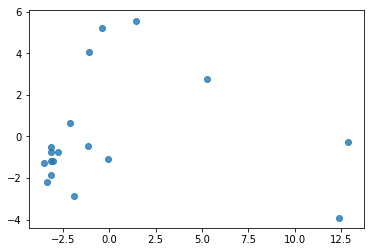

In [37]:
pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(X)

plt.scatter(df_pca[:,0], df_pca[:,1], alpha=0.8)

2

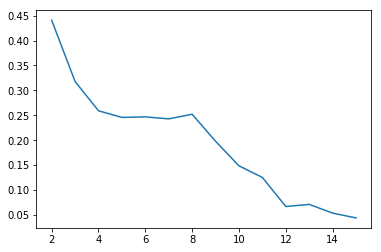

In [38]:
draw_sil_score(X,range(2,16))

In [59]:
clf = KMeans(n_clusters=4)
clf.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [60]:
clusters = pd.DataFrame(index=df.T.index).reset_index()
clusters['label'] = clf.labels_
for el in clusters.groupby('label')['index'].apply(lambda x: ' '.join(x)).values:
    print(el)

Film-Noir Documentary
Romance Horror Adventure Comedy Thriller War Action Mystery Crime Sci-Fi Fantasy Drama
Children Animation Musical
Western


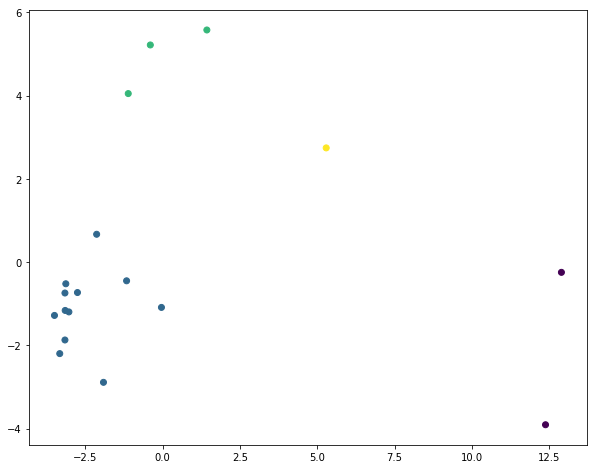

In [65]:
plt.figure(figsize=(10,8))
plt.scatter(df_pca[:,0], df_pca[:,1],c=clf.labels_)

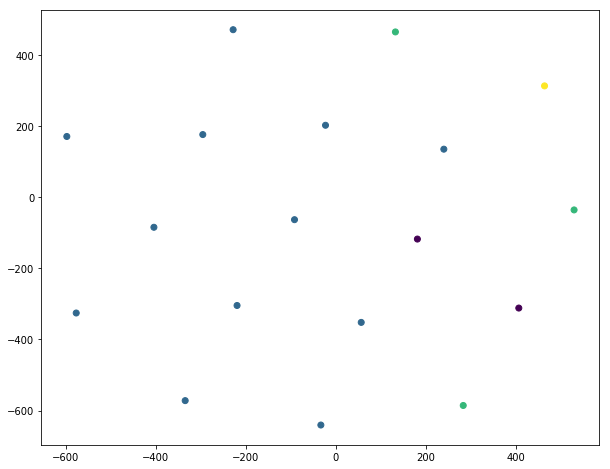

In [67]:
tsne = TSNE(n_components=2, random_state=42, init='pca')
df_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10,8))
plt.scatter(df_tsne[:,0], df_tsne[:,1], c=clf.labels_)

![](http://tech.krutovtalks.ru/content/images/2017/06/hate.jpg)

## Бонус секция

Можно найти центры кластеров по фотографиям людей....

In [41]:
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50, 
                resize=0.4)

Ariel Sharon: 77 photos.
Colin Powell: 236 photos.
Donald Rumsfeld: 121 photos.
George W Bush: 530 photos.
Gerhard Schroeder: 109 photos.
Hugo Chavez: 71 photos.
Jacques Chirac: 52 photos.
Jean Chretien: 55 photos.
John Ashcroft: 53 photos.
Junichiro Koizumi: 60 photos.
Serena Williams: 52 photos.
Tony Blair: 144 photos.


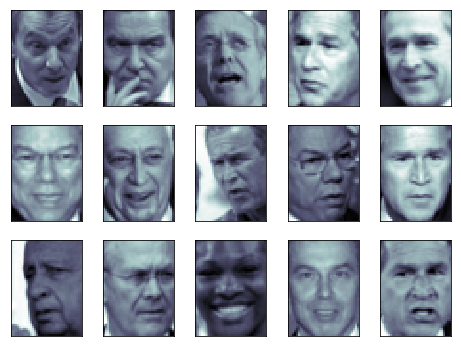

In [42]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap='bone')

for i, name in enumerate(lfw_people.target_names):
    print("{}: {} photos.".format(name, (lfw_people.target == i).sum()))

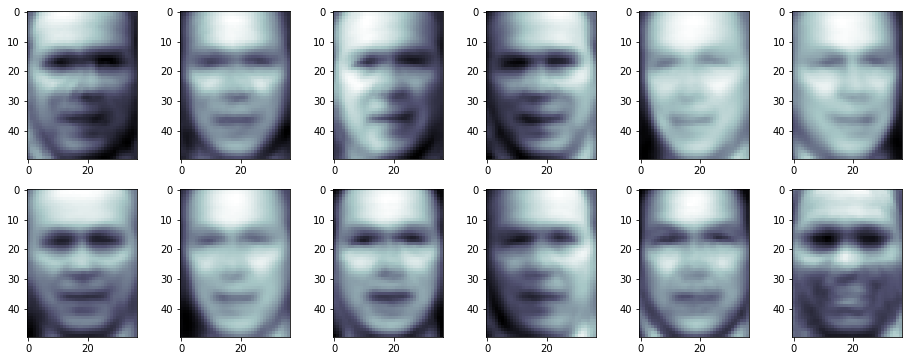

In [43]:
k = KMeans(n_clusters=12, random_state=42, n_init=50)
k.fit(lfw_people.data)

plt.figure(figsize=(16, 6))

for i, center in enumerate(k.cluster_centers_):
    plt.subplot(2, 6, i + 1)
    plt.imshow(center[:].reshape([50,37]), cmap='bone')

.

.

.

.

.

.

.

.

.
## Бонусная секция

Анализ изменений стандартов красоты девушек на основе статистики журнала Playboy за последние 55 лет.

Мы с вами проверим, можно ли с помощью KMeans определить кластеры по размерам и соотнести их с годом.

In [44]:
data = pd.read_csv('../../data/girls.csv')
data.head()

,Month,Year,Bust,Waist,Hips,Height,Weight
0,December,1953,91,61,91,165,54
1,March,1954,86,61,89,168,54
2,July,1955,91,61,91,166,52
3,December,1955,91,61,91,166,52
4,July,1956,91,61,86,157,48


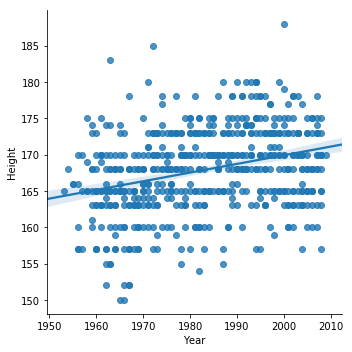

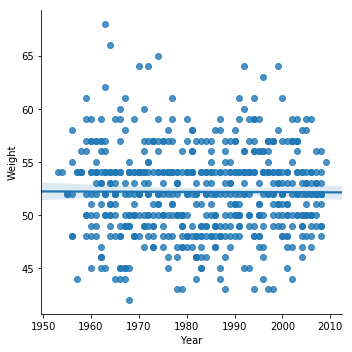

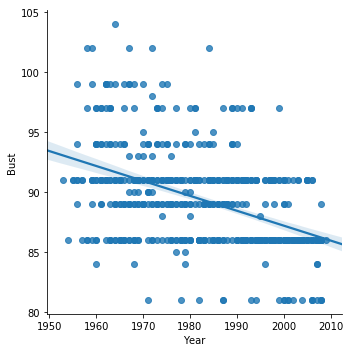

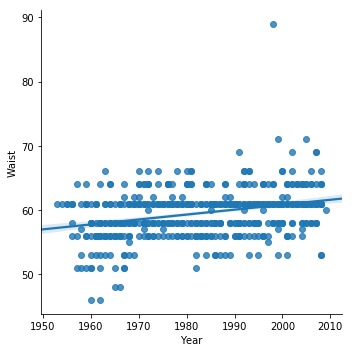

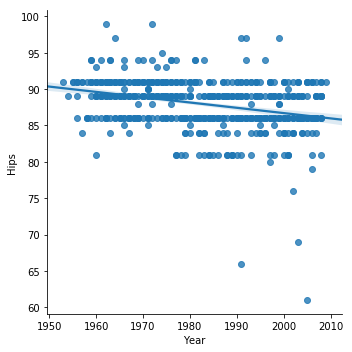

In [45]:
sns.lmplot(x='Year', y='Height', data=data)
sns.lmplot(x='Year', y='Weight', data=data)
sns.lmplot(x='Year', y='Bust',   data=data)
sns.lmplot(x='Year', y='Waist',  data=data)
sns.lmplot(x='Year', y='Hips',   data=data)

Вывод:

|Метрика|Изменение|
|-------|
|Рост|+|
|Вес|=|
|Грудь|-|
|Талия|=|
|Бедра|-|

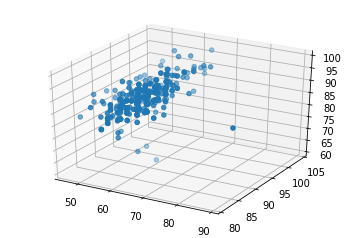

In [46]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['Waist'], data['Bust'], data['Hips'])

Ничего не видно на триде графике. Нужно спроецировать его на плоскость каким-то хитрым способом. 

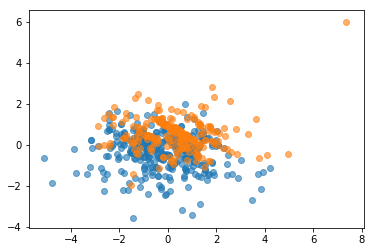

In [47]:
from sklearn.decomposition import PCA  # инструмент понижения размерности
from sklearn.preprocessing import RobustScaler  # нормальзация признаков

pca = PCA(n_components=2)
s = RobustScaler()
p = pca.fit_transform(s.fit_transform(data[['Bust','Waist','Hips', 'Height', 'Weight']]))

data['px'] = p[:,0]
data['py'] = p[:,1]

date = 1990
old = data[data['Year'] < date]
new = data[data['Year'] >= date]
plt.scatter(old['px'], old['py'], alpha=0.6)
plt.scatter(new['px'], new['py'], alpha=0.6)

4


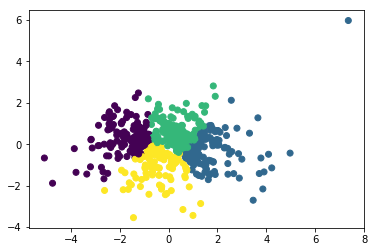

In [48]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=4)
x = data[['Bust','Waist','Hips', 'Height', 'Weight']]
clf.fit(s.fit_transform(x))

data['label'] = clf.labels_
plt.scatter(data['px'], data['py'], c=clf.labels_)
print(len(set(clf.labels_)))

,Bust,Waist,Hips,Height,Weight
label,,,,,
0,87.006579,56.203947,84.940789,163.223684,47.796053
1,91.992857,62.892857,90.728571,172.457143,56.514286
2,87.420000,61.190000,87.375000,168.310000,51.990000
3,92.366071,56.875000,89.544643,167.750000,52.991071


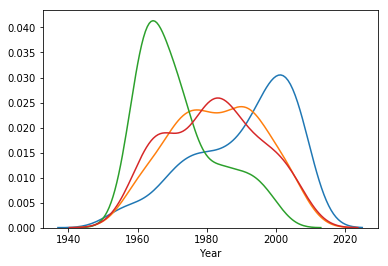

In [49]:
for i in data['label'].unique():
    sns.distplot(data[data['label'] == i]['Year'],hist=False)
data.groupby('label')[['Bust', 'Waist', 'Hips', 'Height', 'Weight']].mean()